In [1]:
import torch
import librosa
import os
import numpy as np
import pandas as pd
from scipy.signal import medfilt

from utils import midi

%matplotlib ipympl
from matplotlib import pyplot as plt
import IPython.display as ipd

# TODO
1. Fix jumps in the quantized detected pitch, e.g frames of [60, 60, 60, 61, 60, 60], turn the note "61" to "60"
2. fuse info from midi and pitch detection to enhance midi:
    - push note-on back in time, if previous frames detected same pitch as note
    - push note-off forward in time, if following frames detected same pitch as note
    - make sure new on/off does not intersect with other notes (if yes, fix other notes start/end)

# Load data

In [2]:
home_dir = os.environ['HOME']
data_dir = f'{home_dir}/ssynth/git_repos/DeepLearningExamples/PyTorch/SpeechSynthesis/HiFiGAN/data_ssynth'
phrase_df = pd.read_csv(f'{data_dir}/phrase_df.csv', index_col = 0).reset_index(drop = True)

fnm = '01_Free_Improv_dynamic_mic_phrase014' #'01_Free_Improv_dynamic_mic_phrase000'
#fnm = '01_Free_Improv_dynamic_mic_phrase008'
pinfo = phrase_df[phrase_df.phrase_id == fnm].iloc[0]
wav_fnm = f'{data_dir}/wavs/{fnm}.wav'
seg, sr = librosa.load(wav_fnm, sr = None)

env, midi_p0, t0, pitch_hz, vprobv, vflag = torch.load(f'cache/{fnm}.pt')
midi_p0 = midi_p0.reset_index(drop = True)
env[env == 0] = env[env > 0].min() # set 0 to the min value. 0 is there becuase of the low-pass, and if we move to dB scale we will get -inf
#--- time-stamps vector. Note is is also the time-stamps of pitch, since hop_len is the same and I used "center = True", meaning window len does not affect the number of samples (there is zero padding)
times = librosa.times_like(env, sr = sr, hop_length = 256, n_fft = None) #--- use the default value for n_fft, since I used "center = True" for the rms calculation, meaning 1st frame is centered around sample 0.

pitch = librosa.hz_to_midi(pitch_hz)
pitch_q = np.round(pitch)

#--- scipy's medfilt has undefined behavior around nans (https://github.com/scipy/scipy/issues/4800), so replace nans with an outlier
pitch_q_mf = pitch_q.copy()
nan_ind = np.isnan(pitch_q_mf)
pitch_q_mf[nan_ind] = 1000
pitch_q_mf = medfilt(pitch_q_mf, 5)
pitch_q_mf[nan_ind] = np.nan

pitch_env = pitch - pitch_q
pitch_env_mf = pitch - pitch_q_mf

#--- midi
file_id =  fnm.split('_phrase')[0] #wav_fnm.split('.')[0] # '01_Free_Improv_dynamic_mic'
midi_fnm = f'{data_dir}/auto_midi/{file_id}.mid'
print(f'reading midi file {os.path.basename(midi_fnm)}')
midi_df, midi_pitch, midi_aftertouch, midi_cc = midi.read_midi_to_df(midi_fnm)
midi.verify_midi(midi_df)
t0 = pinfo.sample_start / sr
midi_p = midi.midi_phrase_from_dataframe(pinfo, midi_df, sr).reset_index(drop = True)

reading midi file 01_Free_Improv_dynamic_mic.mid


# Enhance midi note lenghts using pitch

In [3]:
if False:
    midi_p_copy = midi_p.copy() 
    midi_p_copy['ts_sec'] -= t0
    
    for irow, row in midi_p_copy.iterrows():
        if row.type == 'note_off':
            continue
        note_on = row
        note_off = midi_p_copy.iloc[irow + 1]
        #--- trace pitch backwards and exrtend note-on time if pitch match
        break
    times[(times < note_on.ts_sec) & (pitch_q == note_on.note)]

## Try to "unwrap" the pitch envelope
#### **Note** this needs more investigation, at some notes it works and in some not

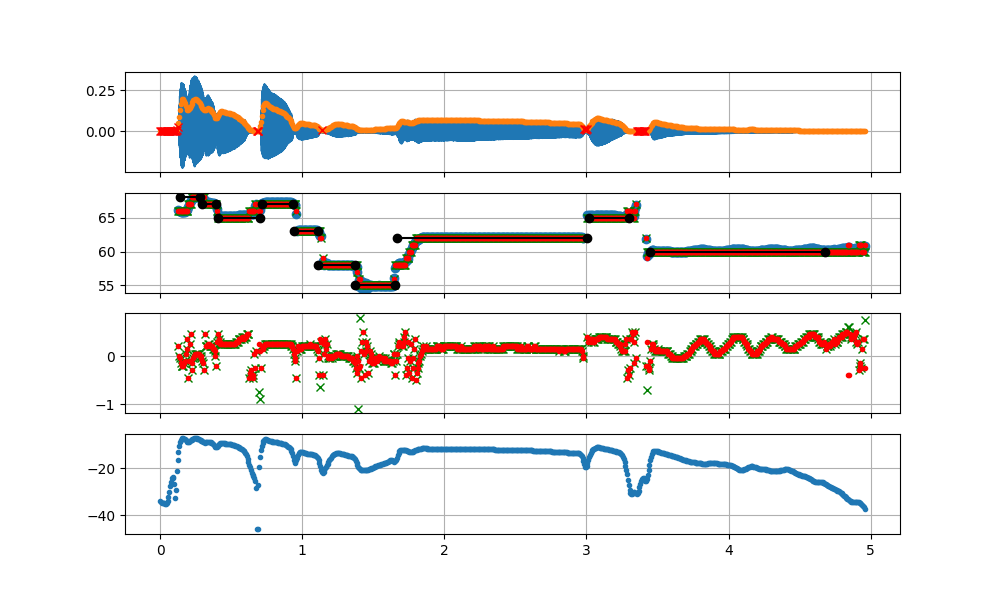

In [4]:
plt.close('all')
fig, ax = plt.subplots(4,1,sharex=True)

#ax[0].plot(time, seg, '.')
ax[0].plot(np.arange(len(seg)) / 44100,seg)
ax[0].plot(times, env, '.')
ax[0].plot(times[~vflag], env[~vflag], 'rx')
ax[0].grid()

ax[1].plot(times, pitch, 'o')
ax[1].plot(times, pitch_q_mf, 'gx')
ax[1].plot(times, pitch_q, 'r.')
for irow, row in midi_p.iterrows():
    if row.type == 'note_off':
        continue
    note_on = row
    note_off = midi_p.loc[irow + 1]
    ax[1].plot([note_on.ts_sec - t0, note_off.ts_sec - t0], [note_on.note, note_on.note], 'ko-')
    
ax[1].grid()

ax[2].plot(times, pitch_env_mf, 'gx')
ax[2].plot(times, pitch_env, 'r.')
ax[2].grid()

#ax[3].plot(np.arange(len(seg)) / 44100,seg)
ax[3].plot(times, 10*np.log10(env),'.')
ax[3].grid()

fig.set_size_inches(10,6)

In [8]:
xlim = ax[0].get_xlim()
t1, t2 = max(0, xlim[0]), min(len(seg), xlim[1]) #.35, .6 #2.16,2.3 #1.6, 2.4
ind1, ind2 = int(sr * t1), int(sr * t2)
#ind1, ind2 = 0, len(seg)
ipd.Audio(data = seg[ind1:ind2], rate = sr/4)

In [38]:
10*np.log10(env.min()), 10*np.log10(np.quantile(env,[0.009,.01,.05,.1]))

(-54.076223373413086,
 array([-34.53479343, -34.41056019, -28.43770448, -25.32160631]))

In [55]:
times[0]

0.0

In [67]:
librosa.times_like(env, sr = sr, hop_length = 256, n_fft = 512)[:5]*44100

array([ 256.,  512.,  768., 1024., 1280.])

In [71]:
librosa.times_like(env, sr = sr, hop_length = 256, n_fft = 1024)[:5]*44100 

array([ 512.,  768., 1024., 1280., 1536.])

In [72]:
env.shape, pitch.shape

((587,), (587,))

In [82]:
midi_p['ts_sec'] -= t0

,type,channel,time,note,velocity,ts_sec
0,note_on,0.0,2623,60.0,6.0,0.077321
1,note_off,0.0,97,60.0,0.0,0.198571
2,note_on,0.0,8,63.0,1.0,0.208571
3,note_off,0.0,160,63.0,0.0,0.408571
4,note_on,0.0,11,65.0,37.0,0.422321
5,note_off,0.0,133,65.0,0.0,0.588571
6,note_on,0.0,8,63.0,1.0,0.598571
7,note_off,0.0,168,63.0,0.0,0.808571
8,note_on,0.0,88,70.0,11.0,0.918571
9,note_off,0.0,1840,70.0,0.0,3.218571


array([ 512.,  768., 1024.])

In [2]:
from env_timegan import *
import tqdm
batch_size = 64
sample_sec = 1 #0.5
history_len = 6
train_loader, val_loader = get_env_train_val_data(batch_size, sample_sec, history_len)

In [7]:
import glob
flist = glob.glob('cache/*.pt')
for fnm in flist:
    env, pitch_hz, vprobv, vflag = torch.load(fnm)
    if len(env) != len(pitch_hz):
        print(fnm)
        break

In [6]:
flist[0]

'cache/02_Free_Improv_dynamic_mic_phrase595.pt'

In [29]:
xx = np.arange(1024)
librosa.feature.rms(y = np.sqrt(xx), frame_length = 512, hop_length = 256, center = True)**2

array([[ 63.75   , 255.5    , 511.5    , 767.5    , 447.75003]],
      dtype=float32)

In [30]:
librosa.times_like(xx, sr = 1, hop_length = 256, n_fft=None)[:4]

array([  0., 256., 512., 768.])

In [44]:
xx = np.arange(1024)
pitch, vflag, vprob = librosa.pyin(xx.astype(float), sr = 44100, fmin=10, fmax=1000,
                                              frame_length = 1024, 
                                              win_length = 512,
                                              hop_length = 256,
                                              resolution = 0.05, #--- 5 cents pitch resolution
                                              center = True,
                                              max_transition_rate = 100)
pitch

array([nan, nan, nan, nan, nan])

,type,channel,time,note,velocity,ts_sec
0,True,True,True,True,True,True
1,True,True,True,True,True,True
2,True,True,True,True,True,True
3,True,True,True,True,True,True
4,True,True,True,True,True,True
5,True,True,True,True,True,True
6,True,True,True,True,True,True
7,True,True,True,True,True,True
8,True,True,True,True,True,True
9,True,True,True,True,True,True
